In [125]:
import xarray as xr
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import io
import os
import re
import requests
from tqdm import tqdm as tq
import matplotlib.pyplot as plt
from matplotlib import rcParams
from physoce import tseries as ts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cmocean.cm as cmo
import scienceplots

In [87]:
plt.style.use('default')
plt.style.use('science')
plt.style.use('high-contrast')
#rcParams['figure.figsize'] = (8,6)
plt.style.use('notebook')
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] ='\\usepackage{amsmath} \\usepackage{amssymb}'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'

In [6]:
def list_files(url, tag=r'.*\.nc$'):
    """
    Function to create a list of the netCDF data files in the THREDDS catalog
    created by a request to the M2M system.

    :param url: URL to a THREDDS catalog specific to a data request
    :param tag: regex pattern used to distinguish files of interest
    :return: list of files in the catalog with the URL path set relative to the
        catalog
    obtained from 2022 OOIFB workshop 
    """
    with requests.session() as s:
        page = s.get(url).text

    soup = BeautifulSoup(page, 'html.parser')
    pattern = re.compile(tag)
    nc_files = [node.get('href') for node in soup.find_all('a', text=pattern)]
    nc_files = [re.sub('catalog.html\?dataset=', '', file) for file in nc_files]
    return nc_files
#https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_host-adcp_velocity_earth/catalog.html

In [7]:
#get nitrate data
# setup defaults to use in subsequent data queries
refdes = "CE02SHSM-RID26-01-ADCPTA000";
method = "recovered_inst";
stream = "adcp_velocity_earth";

# construct the OOI Gold Copy THREDDS catalog URL for this data set
base_url = "https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/";
url = base_url + ('-').join([refdes, method, stream]) + '/catalog.html'
url #check to ensure URL is correct

'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth/catalog.html'

In [8]:
tag = r'deployment000[2-9].*ADCP.*.nc$|deployment001[0-9].*ADCP.*.nc$' #setup regex for files we want (*=anything,$=end of line)
nc_files = list_files(url, tag)
file_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/'
nc_url = [file_url + i + '#mode=bytes' for i in nc_files] #combine files, add mode to ensure download works
#nc_url #can check urls here

['https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth/deployment0002_CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth_20151007T211500-20160516T210000.nc#mode=bytes',
 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth/deployment0003_CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth_20160517T213000-20160928T154500.nc#mode=bytes',
 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth/deployment0004_CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_velocity_earth_20160926T213004.970000-20170422T131504.970000.nc#mode=bytes',
 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSM-RID26-01-ADCPTA000-recovered_inst-adcp_vel

In [9]:
#load datasets
ds = [] #empty arrays for datasets
for i,f in (enumerate(tq(nc_url))):
    r = requests.get(f, timeout=(3.05, 120)) 
    if r.ok:                                #ensure request worked
        ds.append(xr.load_dataset(io.BytesIO(r.content))) 
        ds[i].load()
        ds[i] = ds[i].swap_dims({'obs':'time'}).resample(time='15min').mean()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]C:\Users\asche\.conda\envs\po\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Unable to import google auth packages


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:46<00:00,  7.60s/it]


In [11]:
ds_con = xr.concatenate(ds).sortby('time').resample(time='15min',skipna=True).mean()

In [81]:
sm = -10 # mask above this depth
bm = -50 # mask below this depth
time = ds_con['time']
bin_depths = -ds_con['bin_depths'].mean(dim='time').where(
    (-ds_con['bin_depths'].mean(dim='time')<sm)&((-ds_con['bin_depths'].mean(dim='time')>bm)),drop=True
)
east = ds_con['eastward_seawater_velocity'].T.where(
    (-ds_con['bin_depths'].mean(dim='time')<sm)&((-ds_con['bin_depths'].mean(dim='time')>bm)),drop=True
)
north = ds_con['northward_seawater_velocity'].T.where(
    (-ds_con['bin_depths'].mean(dim='time')<sm)&((-ds_con['bin_depths'].mean(dim='time')>bm)),drop=True
)
up = ds_con['upward_seawater_velocity'].T.where(
    (-ds_con['bin_depths'].mean(dim='time')<sm)&((-ds_con['bin_depths'].mean(dim='time')>bm)),drop=True
)

In [93]:
ds_out = []

ds_out.append(bin_depths)
ds_out.append(east)
ds_out.append(north)
ds_out.append(up)

In [106]:
ds_out = xr.combine_by_coords(ds_out).set_coords('bin_depths').swap_dims({'bin':'bin_depths'}).reset_coords('bin', drop=True)

In [107]:
ds_out = ds_out.rename({
    'bin_depths':'depth',
    'eastward_seawater_velocity':'u',
    'northward_seawater_velocity':'v',
    'upward_seawater_velocity':'w'
})

In [109]:
ds_out.u.attrs['units']='m/s'
ds_out.v.attrs['units']='m/s'
ds_out.w.attrs['units']='m/s'
ds_out.u.attrs['description']='Eastward sea velocity'
ds_out.v.attrs['description']='Northward sea velocity'
ds_out.w.attrs['description']='Upward sea velocity'
ds_out.depth.attrs['units']='m'
ds_out.depth.attrs['description']='Depth below sea level (negative downwards)'

In [131]:
# depth average for princ ax
uda = ds_out.u.mean(dim='depth')
vda = ds_out.v.mean(dim='depth')
# rotate into princ ax
theta,major,minor = ts.princax(uda,vda)
temp = ts.rot(ds_out['u'],ds_out['v'],90-theta)
ds_out['cs'] = (['depth','time'],temp[0])
ds_out['as'] = (['depth','time'],temp[1])

In [150]:
ds_out['cs'].attrs['units']='m/s'
ds_out['cs'].attrs['description']='Cross-shelf sea velocity obtained through principal axis analysis'
ds_out['as'].attrs['units']='m/s'
ds_out['as'].attrs['description']='Along-shelf sea velocity obtained through principal axis analysis'

In [160]:
#check output
ds_out

<xarray.Dataset>
Dimensions:  (depth: 40, time: 245071)
Coordinates:
  * depth    (depth) float64 -10.3 -11.3 -12.3 -13.3 ... -46.3 -47.3 -48.3 -49.3
  * time     (time) datetime64[ns] 2015-10-07T21:15:00 ... 2022-10-03T16:45:00
Data variables:
    u        (depth, time) float64 0.03663 0.05382 0.07718 ... 0.02622 0.03302
    v        (depth, time) float64 0.1725 0.1075 0.21 ... 0.1103 0.2814 0.2517
    w        (depth, time) float64 0.0 -0.035 -0.021 ... -0.066 -0.028 -0.039
    cs       (depth, time) float64 -0.03235 0.008457 ... -0.08375 -0.06609
    as       (depth, time) float64 0.1734 0.1199 0.2235 ... 0.1068 0.2699 0.2451

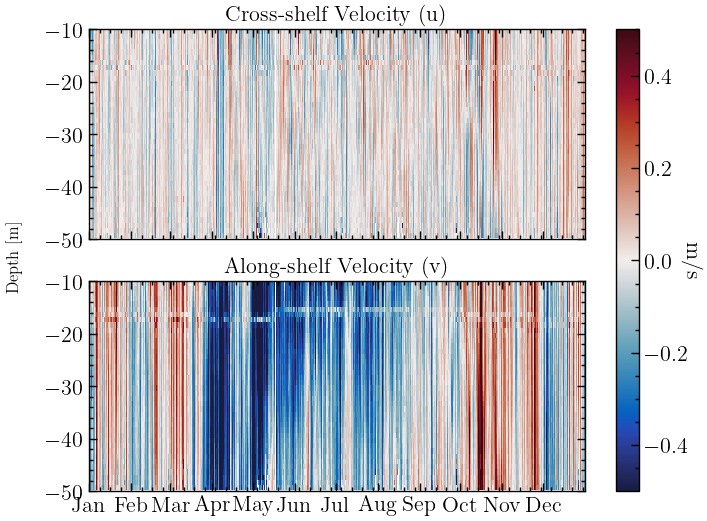

In [169]:
#can plot output 

fig, axes = plt.subplots(2, sharex=True)
#fig.set_size_inches(20, 15)

p0 = axes[0].pcolormesh(ds_out_2016.time, ds_out_2016.depth, ds_out_2016.cs,
                        cmap=cmo.balance,vmin=-0.5,vmax=0.5)

axes[0].set_title('Cross-shelf Velocity (u)')
axes[0].set_ylim(-50,-10)

p1 = axes[1].pcolormesh(ds_out_2016.time, ds_out_2016.depth, ds_out_2016['as'],
                        cmap=cmo.balance,vmin=-0.5,vmax=0.5)
axes[1].set_title('Along-shelf Velocity (v)')
axes[1].set_ylim(-50,-10)
#axes[1].invert_yaxis()

fig.supylabel('Depth [m]')

'''
p2 = axes[2].pcolormesh(time.values, bin_depths.values, up.values, 
                        cmap=cmo.balance,vmin=nmin,vmax=umax)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_ylim(-50,-10)
#axes[2].invert_yaxis()
axes[2].set_xlabel('Time')
'''
cbar = fig.colorbar(p0,ax=axes.ravel().tolist())
cbar.ax.set_ylabel('m/s', rotation=270,labelpad=10)



locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')


#plt.plot(date_list,y)
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.savefig('./imgs/adcp_data.png',dpi=600)


In [166]:
# save output - change path here
ds_out.to_netcdf('./data/ceo2shsm_adcp_data_all.nc')
ds_out_2016.to_netcdf('./data/ceo2shsm_adcp_data_2016.nc')